# colab shenanigans

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DATASET_NAME = 'meta_aorta'

In [ ]:
zip_file_path = f'/content/gdrive/MyDrive/Aorta/{DATASET_NAME}.zip'

In [ ]:
!unzip -q {zip_file_path} -d /content

In [ ]:
!pip install -q segmentation-models-pytorch
!pip install -q opencv-python==4.5.5.62
!pip install --upgrade -q albumentations==1.1.0

     |████████████████████████████████| 88 kB 5.2 MB/s 
     |████████████████████████████████| 376 kB 59.5 MB/s 
     |████████████████████████████████| 58 kB 7.7 MB/s 
     |████████████████████████████████| 60.4 MB 1.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 102 kB 8.1 MB/s 
     |████████████████████████████████| 47.8 MB 46 kB/s 


In [ ]:
!pip -q install sparse

     |████████████████████████████████| 77 kB 4.6 MB/s eta 0:00:011


# Pipeline

In [2]:
import segmentation_models_pytorch as smp

In [3]:
import pandas as pd
def list_dict_mean(dictionary:dict):
    return pd.DataFrame(dictionary).median()

In [4]:
def plotter(train_logs, valid_logs, metrics):
    for param in metrics:
        tr_lst = [d[param] for d in train_logs]
        val_lst = [d[param] for d in valid_logs]
        
        plt.title(f'Plot for {param}')
        plt.plot(tr_lst,label = 'Train')
        plt.plot(val_lst,label = 'Validation')
        plt.legend()
        plt.show()

In [5]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

## DataSet

### Numpy saved dataset

import os

from torch.utils import data
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

class npyDataset(data.Dataset):
    
    # initialise function of class
    def __init__(self, root, augmentations = None,image_only_aug = None, preprocessing = None):
        # the data directory 
        self.root = root
        # the list of filename
        self.filenames = os.listdir(os.path.join(root,'images'))
        #self.target_transform = target_transform
        self.augmentation = augmentations
        self.image_only_aug = image_only_aug
c        self.preprocessing = preprocessing

    # obtain the sample with the given index
    def __getitem__(self, index):
        # obtain filenames from list
        image_filename = self.filenames[index]
        # Load data and label
        image = cv2.imread(os.path.join(self.root,'images', image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        pre, ext = os.path.splitext(image_filename)
        mask_filename =  pre + '.npy'
        
        with open(os.path.join(self.root,'masks', mask_filename), 'rb') as f:
            mask = np.load(f)
        
        #made binary
        mask = (mask != 0).astype('float')
                   
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        
        if self.image_only_aug:
            sample = self.image_only_aug(image=image)
            image = sample['image']
            
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        image=image.float()
        '''
        # universal preprocessing
        image = TF.to_tensor(tr['image'])
        image = TF.normalize(image,(0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
        mask = tr['mask']
        '''
        # output of Dataset must be tensor so tensor in transforms
        return image, mask
    
    # the total number of samples (optional)
    def __len__(self):
        return len(self.filenames)

import os

from torch.utils import data
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

class npyDatasetInMem(data.Dataset):
    
    # initialise function of class
    def __init__(self, root, augmentations = None,image_only_aug = None, preprocessing = None):
        # the data directory 
        self.root = root
        # the list of filename
        self.filenames = os.listdir(os.path.join(root,'images'))
        #self.target_transform = target_transform
        self.augmentation = augmentations
        self.image_only_aug = image_only_aug
        self.preprocessing = preprocessing
        
        self.images = []
        self.masks = []
        for image_filename in self.filenames:
            img = cv2.imread(os.path.join(self.root,'images', image_filename))
            self.images.append(img)
            
            pre, ext = os.path.splitext(image_filename)
            mask_filename =  pre + '.npy'
            
            with open(os.path.join(self.root,'masks', mask_filename), 'rb') as f:
                mask = np.load(f)
                
            mask = (mask != 0).astype('float')
            self.masks.append(mask)
        
        self.images = np.array(self.images,dtype=object)
        self.masks = np.array(self.masks,dtype=object)

    # obtain the sample with the given index
    def __getitem__(self, index):
        # obtain filenames from list
        image = self.images[index]
        mask = self.masks[index]
                   
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        
        if self.image_only_aug:
            sample = self.image_only_aug(image=image)
            image = sample['image']
            
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        image=image.float()
        '''
        # universal preprocessing
        image = TF.to_tensor(tr['image'])
        image = TF.normalize(image,(0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
        mask = tr['mask']
        '''
        # output of Dataset must be tensor so tensor in transforms
        return image, mask
    
    # the total number of samples (optional)
    def __len__(self):
        return len(self.filenames)

### Pickled-sparse dataset

import os

from torch.utils import data
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from scipy import sparse
import pickle
def load_sparce_nparray(path:str):
    '''
    Loads npy array as sparce pickled scipy matrix.
    '''
    with open(path,'rb') as file:
        s = pickle.load(file)
    
    return s.toarray()


class sparseDataset(data.Dataset):
    
    # initialise function of class
    def __init__(self, root, augmentations = None,image_only_aug = None, preprocessing = None):
        # the data directory 
        self.root = root
        # the list of filename
        self.filenames = os.listdir(os.path.join(root,'images'))
        #self.target_transform = target_transform
        self.augmentation = augmentations
        self.image_only_aug = image_only_aug
        self.preprocessing = preprocessing

    # obtain the sample with the given index
    def __getitem__(self, index):
        # obtain filenames from list
        image_filename = self.filenames[index]
        # Load data and label
        image = cv2.imread(os.path.join(self.root,'images', image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        

        pre, ext = os.path.splitext(image_filename)
        mask_filename =  pre + '.pickle'
        
        mask = load_sparce_nparray(os.path.join(self.root,'masks', mask_filename))
                   
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.image_only_aug:
            sample = self.image_only_aug(image=image)
            image = sample['image']
   
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
               
        #image=image.float()
        '''
        # universal preprocessing
        image = TF.to_tensor(tr['image'])
        image = TF.normalize(image,(0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
        mask = tr['mask']
        '''
        # output of Dataset must be tensor so tensor in transforms
        return image, mask
    
    # the total number of samples (optional)
    def __len__(self):
        return len(self.filenames)


class sparseDatasetInMem(data.Dataset):
    
    # initialise function of class
    def __init__(self, root, augmentations = None,image_only_aug = None, preprocessing = None):
        # the data directory 
        self.root = root
        # the list of filename
        self.filenames = os.listdir(os.path.join(root,'images'))
        #self.target_transform = target_transform
        self.augmentation = augmentations
        self.image_only_aug = image_only_aug
        self.preprocessing = preprocessing
        
        self.images = []
        self.masks = []
        for image_filename in self.filenames:
            img = cv2.imread(os.path.join(self.root,'images', image_filename))
            self.images.append(img)
            
            pre, ext = os.path.splitext(image_filename)
            mask_filename =  pre + '.pickle'
            
            mask = load_sparce_nparray(os.path.join(self.root,'masks', mask_filename))
            self.masks.append(mask)
        
        self.images = np.array(self.images,dtype=object)
        self.masks = np.array(self.masks,dtype=object)

    # obtain the sample with the given index
    def __getitem__(self, index):
        # obtain filenames from list
        image = self.images[index]
        mask = self.masks[index]
                   
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        
        if self.image_only_aug:
            sample = self.image_only_aug(image=image)
            image = sample['image']
            
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        image=image.float()
        '''
        # universal preprocessing
        image = TF.to_tensor(tr['image'])
        image = TF.normalize(image,(0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
        mask = tr['mask']
        '''
        # output of Dataset must be tensor so tensor in transforms
        return image, mask
    
    # the total number of samples (optional)
    def __len__(self):
        return len(self.filenames)

### NPZ

In [1]:
import os

from torch.utils import data
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import sparse
import pickle

def load_sparce_npz(path:str):
    '''
    Loads npy array as sparce pickled scipy matrix.
    '''
    with open(path,'rb') as file:
        s = pickle.load(file)
    
    # convert to numpy array
    s = s.todense()
    if len(s.shape) == 2:
      return s
    return np.transpose(s,[1,2,0])
    


class sparseDatasetNpz(data.Dataset):
    
    # initialise function of class
    def __init__(self, root, augmentations = None,image_only_aug = None,mask_only_aug = None, preprocessing = None):
        # the data directory 
        self.root = root
        # the list of filename
        self.filenames = os.listdir(os.path.join(root,'images'))
        #self.target_transform = target_transform
        self.augmentation = augmentations
        self.image_only_aug = image_only_aug
        self.mask_only_aug = mask_only_aug
        self.preprocessing = preprocessing

    # obtain the sample with the given index
    def __getitem__(self, index):
        # obtain filenames from list
        image_filename = self.filenames[index]
        # Load data and label
        image = cv2.imread(os.path.join(self.root,'images', image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        pre, ext = os.path.splitext(image_filename)
        mask_filename =  pre + '.pickle'

        #print(os.path.join(self.root,'masks', mask_filename))
        mask = load_sparce_npz(os.path.join(self.root,'masks', mask_filename))
                   
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        
        if self.image_only_aug:
            sample = self.image_only_aug(image=image)
            image = sample['image']
            
        if self.mask_only_aug:
            sample = self.mask_only_aug(mask=mask)
            mask = sample['mask']
            
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        #image=image.float()
        '''
        # universal preprocessing
        image = TF.to_tensor(tr['image'])
        image = TF.normalize(image,(0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
        mask = tr['mask']
        '''
        # output of Dataset must be tensor so tensor in transforms
        return image, mask
    
    # the total number of samples (optional)
    def __len__(self):
        return len(self.filenames)


class sparseDatasetNpzInMem(data.Dataset):
    
    # initialise function of class
    def __init__(self, root, augmentations = None,image_only_aug = None, preprocessing = None):
        # the data directory 
        self.root = root
        # the list of filename
        self.filenames = os.listdir(os.path.join(root,'images'))
        #self.target_transform = target_transform
        self.augmentation = augmentations
        self.image_only_aug = image_only_aug
        self.preprocessing = preprocessing
        
        self.images = []
        self.masks = []
        for image_filename in self.filenames:
            img = cv2.imread(os.path.join(self.root,'images', image_filename))
            self.images.append(img)
            
            pre, ext = os.path.splitext(image_filename)
            mask_filename =  pre + '.pickle'
            
            mask = load_sparce_npz(os.path.join(self.root,'masks', mask_filename))
            self.masks.append(mask)
        
        self.images = np.array(self.images,dtype=object)
        self.masks = np.array(self.masks,dtype=object)

    # obtain the sample with the given index
    def __getitem__(self, index):
        # obtain filenames from list
        image = self.images[index]
        mask = self.masks[index]
                   
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        
        if self.image_only_aug:
            sample = self.image_only_aug(image=image)
            image = sample['image']
            
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        image=image.float()
        '''
        # universal preprocessing
        image = TF.to_tensor(tr['image'])
        image = TF.normalize(image,(0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))
        mask = tr['mask']
        '''
        # output of Dataset must be tensor so tensor in transforms
        return image, mask
    
    # the total number of samples (optional)
    def __len__(self):
        return len(self.filenames)

Augmentation remainder
https://www.quantib.com/blog/image-augmentation-how-to-overcome-small-radiology-datasets

In [6]:
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt

import random

IMAGE_SIZE = 224

universal_transform = A.Compose([
    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    #A.RandomCrop(width=256, height=256),
    A.Rotate(p=0.6),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.RandomBrightnessContrast(p=0.35),
    A.RandomResizedCrop(IMAGE_SIZE,IMAGE_SIZE,p=0.3)
])

In [7]:
image_transform = A.Compose([
    A.RandomBrightnessContrast(p=0.35)
    #A.RandomResizedCrop(IMAGE_SIZE,IMAGE_SIZE,p=0.3)
])

In [8]:
val_transform = A.Compose([
    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
])

In [9]:
def tanh_mask_transform(mask):
    mask[mask == 0] = -1
    return {'mask':mask}
mask_transform = tanh_mask_transform

https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-model-building-6ab09d6a0862

https://www.kaggle.com/balraj98/unet-with-pretrained-resnet50-encoder-pytorch

In [10]:
#https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

def to_tensor(x, **kwargs):
    return TF.to_tensor(x)
    #return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn = None):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    if preprocessing_fn:
      _transform = [
          A.Lambda(image=preprocessing_fn),
          A.Lambda(image=to_tensor, mask=to_tensor),
      ]
    else:
      _transform = [
          A.Lambda(image=to_tensor, mask=to_tensor),
      ]
    return A.Compose(_transform)

## Model

In [12]:
from TransUNet.networks.vit_seg_modeling import VisionTransformer as ViT_seg
from TransUNet.networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg

In [21]:
vit_name = 'R50-ViT-B_16'
vit_patches_size = 16
pretrained_path = r"C:\diploma\imagenet21k_R50+ViT-B_16.npz"

config_vit = CONFIGS_ViT_seg[vit_name]
config_vit.n_classes = 1
config_vit.n_skip = 3
if vit_name.find('R50') != -1:
    config_vit.patches.grid = (int(IMAGE_SIZE / vit_patches_size), int(IMAGE_SIZE / vit_patches_size))

In [22]:
model = ViT_seg(config_vit, img_size=IMAGE_SIZE, num_classes=1)
weights = np.load(pretrained_path)
model.load_from(weights=weights)

### ResNet50 + Unet

In [10]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=3, 
    activation=ACTIVATION,
)


In [11]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

https://analyticsindiamag.com/hands-on-transunet-transformers-for-medical-image-segmentation/

# New library

In [23]:
import torch
from self_attention_cv.transunet import TransUnet
import timm
vit = timm.create_model('vit_base_patch16_224', pretrained=True)

model = TransUnet(in_channels=3, img_dim=224, vit_blocks=8,
vit_dim_linear_mhsa_block=512, classes=1,vit_transformer=vit,vit_channels=3584)


## Initializing dataset

### NPZ stuff

In [13]:
dataset_dir = r'C:/diploma/datasets/meta_aorta/'
dataset = sparseDatasetNpz(dataset_dir,
                           augmentations=universal_transform,
                           image_only_aug=image_transform,
                           mask_only_aug=None,
                           preprocessing=None)
print(len(dataset))

6524


In [14]:
a = dataset[0]

In [29]:
b = A.Normalize()(image=a[0])['image']

In [33]:
c = a[0]/255

(array([47025.,  1803.,  1968.,  1650., 52008., 42987.,  2187.,   633.,
          201.,    66.]),
 array([0.        , 0.09254902, 0.18509804, 0.27764706, 0.37019608,
        0.4627451 , 0.55529412, 0.64784314, 0.74039216, 0.83294118,
        0.9254902 ]),
 <BarContainer object of 10 artists>)

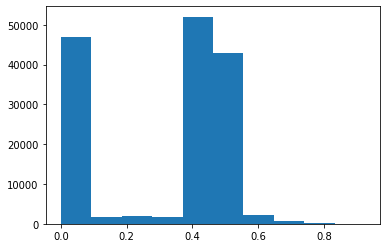

In [32]:
plt.hist((a[0]/255).ravel())

In [12]:
val_dataset = sparseDatasetNpz(os.path.join(dataset_dir,'validation'), 
                               augmentations=val_transform,
                               image_only_aug=None,
                               mask_only_aug=None,
                               preprocessing=get_preprocessing(None))
print(len(val_dataset))

1483


# Additional models

### SWIN

In [14]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

In [15]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [16]:
%%bash

UsageError: %%bash is a cell magic, but the cell body is empty.


In [ ]:
import timm
swin = timm.create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=1)

In [ ]:
swin

In [ ]:
swin.head = model.segmentation_head

In [ ]:
import torch.nn as nn
new_model = nn.Sequential(*list(swin.children())[:-1],list(model.children())[-1])

In [ ]:
new_model

In [ ]:
model = new_model

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for param in list(model.parameters())[-2:]:
    param.requires_grad = True

In [ ]:
params = model.state_dict()
params.keys()

In [ ]:
for name, param in model.named_parameters():
  if param.requires_grad:print(name)

### TransUNet

In [ ]:
!git clone https://github.com/Beckschen/TransUNet.git

In [ ]:
!cd TransUNet && pip install -r requirements.txt 

In [ ]:
MODEL_NAME = 'R50-ViT-B_16'

In [ ]:
!wget https://storage.googleapis.com/vit_models/imagenet21k/R50%2BViT-B_16.npz 

In [ ]:
from TransUNet.networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from TransUNet.networks.vit_seg_modeling import VisionTransformer as ViT_seg
import numpy as np


args = {'num_classes':1,
        'n_skip':3,
        'vit_name':MODEL_NAME,
        'img_size':224,
        'vit_patches_size':16,
        }


config_vit = CONFIGS_ViT_seg[args['vit_name']]
config_vit.n_classes = args['num_classes']
config_vit.n_skip = args['n_skip']
if args['vit_name'].find('R50') != -1:
    config_vit.patches.grid = (int(args['img_size'] / args['vit_patches_size']), int(args['img_size'] / args['vit_patches_size']))
model = ViT_seg(config_vit, img_size=args['img_size'], num_classes=config_vit.n_classes).cuda()
model.load_from(weights=np.load('/content/R50+ViT-B_16.npz'))

## Loaders and parameters

from torch.utils.data import SubsetRandomSampler

BATCH_SIZE = 16
NUM_WORKERS = 4

validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                                sampler=valid_sampler)

In [13]:
BATCH_SIZE = 8
NUM_WORKERS = 4

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)

In [37]:
# Set num of epochs
EPOCHS = 20

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Recall(),
    smp.utils.metrics.Fscore()    
]

# define optimizer



In [27]:
import torch.nn.functional as F
class DiceBCELoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.__name__ = 'DiceBCELoss'
    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets.float(), reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE
loss = DiceBCELoss()

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.58E-05


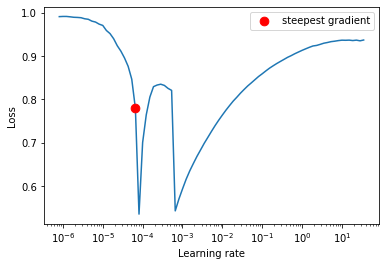

In [40]:
from torch_lr_finder import LRFinder

optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)

lr_finder = LRFinder(model, optimizer, loss, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [39]:
6.58E-05

6.58e-05

## LR schedulers

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode = 'max'
)

## Epochs

In [54]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

## Loading saved model

#load best saved model checkpoint from previous commit (if present)
path_best_model = os.path.join(save_dir,f'{model_name}',f'{model_name}.pth')
if os.path.exists(path_best_model):
    model = torch.load(path_best_model, map_location=DEVICE)
    print('Model loaded!')

## Learn!!!

In [19]:
SAVE_MODEL = True

model_name = 'TransUnet'
save_dir = r"E:\University\ScienceWork\Medicine\AortaStuff\ML\models\aorta"

if SAVE_MODEL:
    if not os.path.exists(os.path.join(save_dir, model_name)):
        os.mkdir(os.path.join(save_dir, model_name))
        print('Created new directory')
    else:
        print('Directory already exists')

Directory already exists


In [20]:
import pickle
def save_model_with_stats(model,train_logs,validation_logs,model_name,save_path):
  model_dir = os.path.join(save_dir,model_name)
  torch.save(model, os.path.join(model_dir,f'{model_name}.pth'))
  
  with open(os.path.join(model_dir,'train_logs.pickle'),'wb') as file:
    pickle.dump(train_logs, file)
  
  with open(os.path.join(model_dir,'validation_logs.pickle'),'wb') as file:
    pickle.dump(validation_logs, file)

In [21]:
print(f'Running on {torch.cuda.get_device_name(0)}')

Running on NVIDIA GeForce GTX 1060 6GB


with open(r"E:\University\ScienceWork\Medicine\AortaStuff\ML\models\aorta\RN50-DeepLabV3_fixed\train_logs.pickle",'rb') as file:
    train_logs_list = pickle.load(file)
with open(r"E:\University\ScienceWork\Medicine\AortaStuff\ML\models\aorta\RN50-DeepLabV3_fixed\validation_logs.pickle",'rb') as file:
    valid_logs_list = pickle.load(file)    

In [21]:
%%time

best_score = 999999999
loss_name = loss.__name__
train_logs_list, valid_logs_list = [], []

for i in range(0, EPOCHS):

    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)
    
    #lr_scheduler.step(valid_logs[loss_name])

    # Save model if a better val IoU score is obtained
    if best_score > valid_logs[loss_name]:
        best_score = valid_logs[loss_name]
        if SAVE_MODEL:
            save_model_with_stats(model,train_logs_list,valid_logs_list,model_name,save_dir)
            #torch.save(model, os.path.join(save_dir,model_save_name))
            print('------------\nModel saved!\n------------')
        else:
            print('------------\nBest iou score!\n------------')

print(best_score)


Epoch: 0
train:   0%|                                                                                                                                                                                                        | 0/544 [00:00<?, ?it/s]

c:\users\alexa\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train:   0%|▏                                                                                                                | 1/544 [00:06<59:24,  6.56s/it, DiceBCELoss - 1.719, iou_score - 0.007328, recall - 0.07883, fscore - 0.01455]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 6.00 GiB total capacity; 4.54 GiB already allocated; 0 bytes free; 4.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [36]:
def check_dataset(dataset):
    for image,mask in dataset:
        fig, axs = plt.subplots(1,3)
        
        axs[0].imshow(image.permute(1, 2, 0))
        axs[1].imshow(mask.permute(1, 2, 0))
        axs[2].imshow(image.permute(1, 2, 0))
        axs[2].imshow(mask.permute(1, 2, 0),alpha=0.5)
        yield

# Double model test

In [15]:
class MyDoubleNet(torch.nn.Module): 
    def __init__(self, first_model_path,second_model_path,device,preprocessing = None):
        super(MyDoubleNet, self).__init__()
        if os.path.exists(first_model_path):
            self.first_model = torch.load(first_model_path, map_location=device)
        else:
            print(f'Error finding model [{first_model_path}]')
            raise 
            
        if os.path.exists(second_model_path):
            self.second_model = torch.load(second_model_path, map_location=device)
        else:
            print(f'Error finding model [{second_model_path}]')
            raise 
        
        self.preprocessing = preprocessing
            

    def forward(self, x):
        first_model_output = self.first_model.predict(x)
        
        if self.preprocessing:
            sample = self.preprocessing(image=first_model_output)
            first_model_output = sample['image']
            
        newx = torch.clone(x)
        newx[:,2,:,:] = first_model_output[:,0,:,:]
        
        output = self.second_model(newx)
        
        return output

In [16]:
model = MyDoubleNet(first_model_path=r"E:\University\ScienceWork\Medicine\AortaStuff\ML\models\aorta\RN50-DeepLabV3_fixed\RN50-DeepLabV3_fixed.pth",
                     second_model_path=r"E:\University\ScienceWork\Medicine\AortaStuff\ML\models\flows\Xception-DeepLabV3\Xception-DeepLabV3.pth",device=DEVICE)

In [52]:
model = torch.load(r"E:\University\ScienceWork\Medicine\AortaStuff\ML\models\aorta\RN50_meta_aorta.pth", map_location=DEVICE)

In [11]:
model

NameError: name 'model' is not defined

In [55]:
valid_logs = valid_epoch.run(valid_loader)

valid: 100%|█| 371/371 [00:24<00:00, 15.01it/s, dice_loss - 0.4896, iou_score - 0.3631, recall - 0.5103, fscore - 0.510


In [19]:
valid_iter = iter(valid_loader)
example = next(valid_iter)

In [18]:
out1 = model(example[0])

torch.Size([12, 3, 512, 512])
torch.Size([12, 1024, 32, 32])
torch.Size([12, 768, 32, 32])
torch.Size([12, 1024, 768])


RuntimeError: The size of tensor a (1024) must match the size of tensor b (196) at non-singleton dimension 1

In [57]:
with open(r"E:\University\ScienceWork\Medicine\AortaStuff\ML\models\aorta\RN50-DeepLabV3_fixed\validation_logs.pickle",'rb') as file:
    v = pickle.load(file)

In [58]:
v

[{'dice_loss': 0.3676855416039046,
  'iou_score': 0.4688824165735163,
  'recall': 0.5313538180004519,
  'fscore': 0.6348583351158049},
 {'dice_loss': 0.3901410089277098,
  'iou_score': 0.44777939951644824,
  'recall': 0.4927166827773192,
  'fscore': 0.6140763202780011},
 {'dice_loss': 0.29572508566017225,
  'iou_score': 0.558448016658362,
  'recall': 0.758166458670403,
  'fscore': 0.7144639803476538},
 {'dice_loss': 0.3176431167353703,
  'iou_score': 0.5234824614317442,
  'recall': 0.6660316950685921,
  'fscore': 0.6836246561497346},
 {'dice_loss': 0.32849722295926154,
  'iou_score': 0.5133695808888208,
  'recall': 0.573221755182985,
  'fscore': 0.6728223127612685},
 {'dice_loss': 0.2638607526099415,
  'iou_score': 0.5877703823833552,
  'recall': 0.6584246032916158,
  'fscore': 0.7371321978519905},
 {'dice_loss': 0.1850127653131575,
  'iou_score': 0.6912383217177979,
  'recall': 0.7709697522413624,
  'fscore': 0.8156764869959218},
 {'dice_loss': 0.168682735823492,
  'iou_score': 0.7149

In [18]:
a = torch.tensor([1,2,3])

In [20]:
a.shape

torch.Size([3])

In [38]:
out1 = model.first_model.predict(example[0].cuda())

In [41]:
newx = torch.clone(example[0])
newx[:,2,:,:] = out1[:,0,:,:]

In [42]:
out2 = model.second_model.predict(newx.cuda())

In [43]:
slice_num = 0

In [44]:
ex_in = example[0][slice_num].numpy().transpose([1,2,0])
ex_out = example[1][slice_num].numpy().transpose([1,2,0])

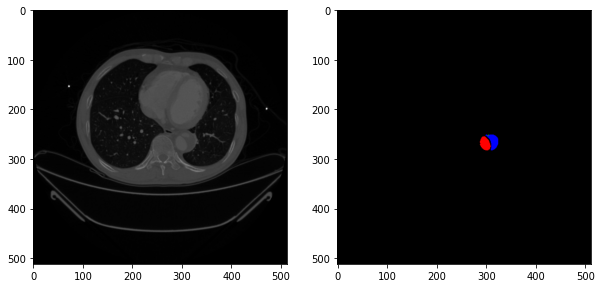

In [45]:
fig, ax = plt.subplots(figsize=(10, 10),ncols=2)
ax[0].imshow(ex_in)
ax[1].imshow(ex_out)

In [46]:
out1_np = out1[slice_num].cpu().numpy().transpose([1,2,0])

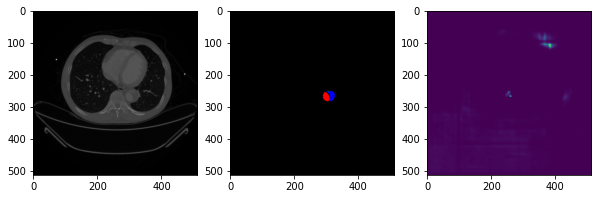

In [49]:
fig, ax = plt.subplots(figsize=(10, 10),ncols=3)
ax[0].imshow(ex_in)
ax[1].imshow(ex_out)
ax[2].imshow(out1_np)

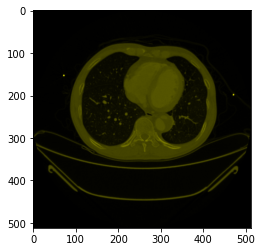

In [48]:
plt.imshow(newx[slice_num].cpu().numpy().transpose([1,2,0]))

In [50]:
out2_np = out2[slice_num].cpu().numpy().transpose([1,2,0])

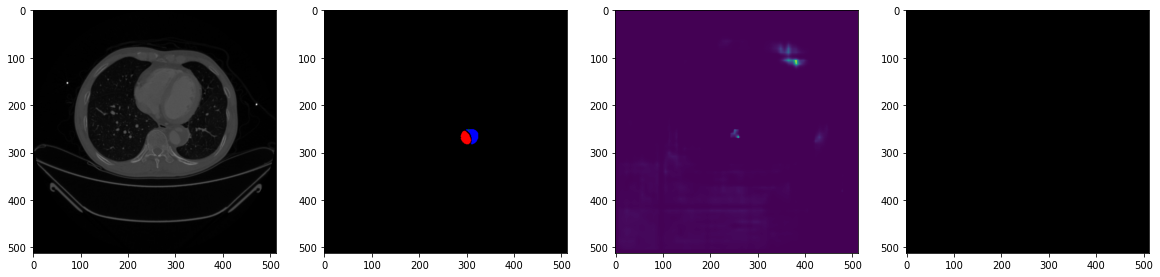

In [51]:
fig, ax = plt.subplots(figsize=(20, 10),ncols=4)
ax[0].imshow(ex_in)
ax[1].imshow(ex_out)
ax[2].imshow(out1_np)
ax[3].imshow(out2_np)

In [33]:
t = torch.rand(12,3,3, 3)
t.shape

torch.Size([12, 3, 3, 3])

In [36]:
t[:,0,:,:] = torch.rand(12,3, 3)

In [50]:
a = check_dataset(dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


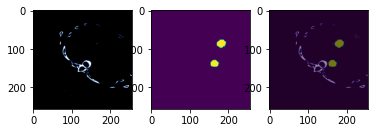

In [56]:
next(a)

In [57]:
del a

In [ ]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [ ]:
dump_tensors()

Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 256 × 64 × 1 × 1
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Parameter: GPU pinned 128 × 256 × 1 × 1
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 128 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 512 × 128 × 1 × 1
Parameter: GPU pinned 512
Parameter: GPU pinned 512
Parameter: GPU pinned 128 × 512 × 1 × 1
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 128 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 512 × 128 × 1 × 1
Parameter: GPU pinned 512
Parameter: GPU pinned 512
Parameter: GPU pinned 128 × 512 × 1 × 1
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 128 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 512 × 128 × 1 × 1
Parameter: GPU pinned 512
Parameter: GPU pinned 512
Parameter: GPU pinned 128 × 512

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: astor.all_symbols is deprecated.  Please use astor.symbol_data.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: astor.treewalk is deprecated.  Please use astor.tree_walk.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: astor.codegen is deprecated.  Please use astor.code_gen.
/usr/local/lib/python3.7/dist-packages/torch/distributed/distributed_c10d.py:182: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  "torch.distributed.reduce_op is deprecated, please use "


Parameter: GPU pinned 64 × 64 × 3 × 3
Parameter: GPU pinned 64 × 3 × 7 × 7
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 64 × 64 × 1 × 1
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 256 × 64 × 1 × 1
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Total size: 2624656144


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: MODES has been renamed to Modes and will be removed in a future version of pywt.


### Plotting learning graphs

In [20]:
params = ['dice_loss','iou_score','recall','fscore']

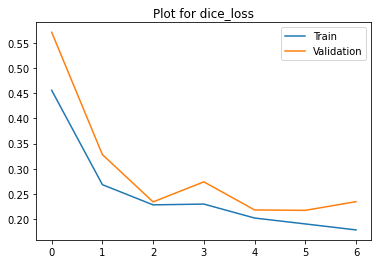

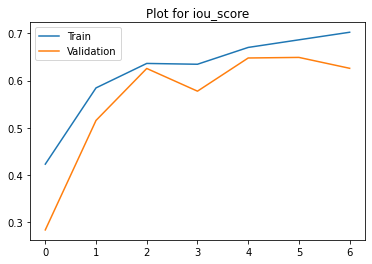

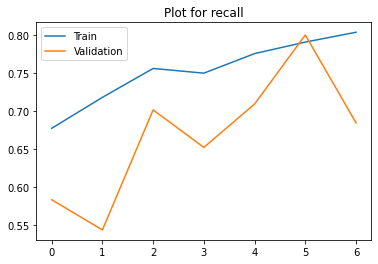

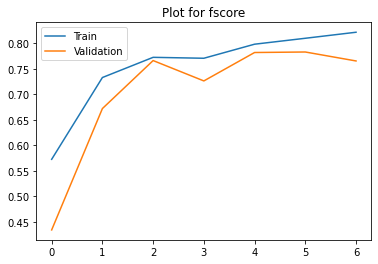

In [21]:
plotter(train_logs_list,valid_logs_list,params)

In [ ]:
plotter(train_logs_list,valid_logs_list,params)

In [ ]:
plotter(train_logs_list,valid_logs_list,params)

In [ ]:
# 50 no sheduler
plotter(train_logs_list,valid_logs_list,params)

In [ ]:
# new_data
plotter(train_logs_list,valid_logs_list,params)

## Evaluate

In [ ]:
EVALUATE_EPOCHS = 10

In [27]:
best_iou_score = 0.0

test_logs = valid_epoch.run(valid_loader)


#print(f'------------\nValidation scores:\n {list_dict_mean(test_logs_list)}\n------------')

valid:  54%|█ | 62/115 [02:39<02:16,  2.57s/it, dice_loss - 0.25, iou_score - 0.6054, recall - 0.7149, fscore - 0.7505]


KeyboardInterrupt: 

## Loading best model

In [ ]:
l_model = torch.load(os.path.join(dataset_dir,model_save_name))

## Looking at results

In [14]:
def show_tensor_image(tensor):
    cpu = tensor.cpu()
    images = cpu[0].permute(1, 2, 0)
    
    im_num = images.shape[2]
    
    fig, axs = plt.subplots(1,im_num)
    
    if im_num == 1:
        axs.imshow(images[:,:])
    else:
        for ch in range(im_num):
            axs[ch].imshow(images[:,:,ch])

In [15]:
valid_iter = iter(valid_loader)

In [16]:
test_input,test_lable = next(valid_iter)
test_input = test_input.cuda()

In [19]:
test_input.shape

torch.Size([8, 3, 224, 224])

In [27]:
a = test_input.cpu()

In [31]:
n = a.permute(0,2,3,1).numpy()

In [36]:
imr = A.Resize(300,300)(image=n[0])

In [38]:
type(imr)

dict

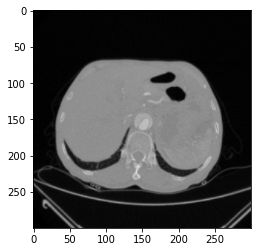

In [39]:
plt.imshow(imr['image'])

In [23]:
test_pred = model.predict(test_input)

### Predict with best model

In [24]:
test_pred = l_model.predict(test_input)

NameError: name 'l_model' is not defined

### All aorta images

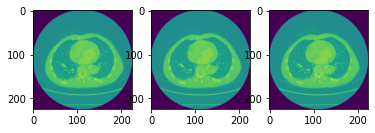

In [25]:
show_tensor_image(test_input)

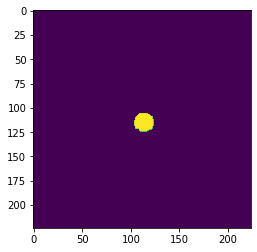

In [17]:
show_tensor_image(test_lable)

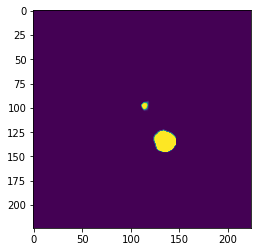

In [27]:
show_tensor_image(test_pred)

### Only top images

In [ ]:
show_tensor_image(test_input)

In [ ]:
show_tensor_image(test_lable)

In [ ]:
show_tensor_image(test_pred)

In [ ]:
show_tensor_image(test_input)

In [ ]:
show_tensor_image(test_lable)

In [ ]:
show_tensor_image(test_pred)

In [ ]:
show_tensor_image(test_input)

In [ ]:
show_tensor_image(test_lable)

In [ ]:
show_tensor_image(test_pred)

Для отчёта

In [ ]:
show_tensor_image(test_input)

In [ ]:
show_tensor_image(test_lable)

In [ ]:
show_tensor_image(test_pred)

In [ ]:
show_tensor_image(test_input)

In [ ]:
cpu = test_input.cpu()
images = cpu[0].permute(1, 2, 0)

im_num = images.shape[2]

fig, axs = plt.subplots(1,im_num)

if im_num == 1:
    axs.imshow(images[:,:])
else:
    for ch in range(im_num):
        axs[ch].imshow(images[:,:,ch])

In [ ]:
plt.imshow(images)
plt.axis('off')

In [ ]:
show_tensor_image(test_lable)

In [ ]:
cpu = test_lable.cpu()
images = cpu[0].permute(1, 2, 0)

In [ ]:
plt.imshow(images)
plt.axis('off')


In [ ]:
show_tensor_image(test_pred)

In [ ]:
cpu = test_pred.cpu()
images = cpu[0].permute(1, 2, 0)
plt.imshow(images)
plt.axis('off')

# Saved Results

## Descending only, ResNet50, Lr_shed = ReduceLROnPlateau

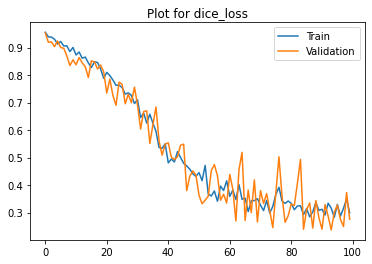

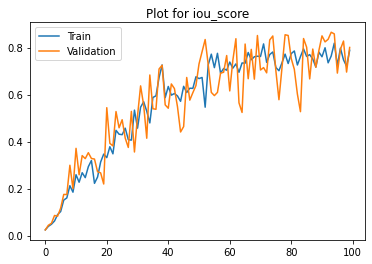

In [ ]:
plotter(train_logs_list,valid_logs_list,params)

In [ ]:
best_iou_score = 0.0
test_logs_list = []

for i in range(0, EVALUATE_EPOCHS):

    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    test_logs = valid_epoch.run(valid_loader)
    test_logs_list.append(test_logs)

    # Save model if a better val IoU score is obtained
    if best_iou_score < test_logs['iou_score']:
        best_iou_score = test_logs['iou_score']



print(f'------------\nValidation scores:\n {list_dict_mean(test_logs_list)}\n------------')


Epoch: 0
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  5.98it/s, dice_loss - 0.3214, iou_score - 0.7412]

Epoch: 1
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  7.54it/s, dice_loss - 0.2638, iou_score - 0.7738]

Epoch: 2
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s, dice_loss - 0.3572, iou_score - 0.6927]

Epoch: 3
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  7.67it/s, dice_loss - 0.3115, iou_score - 0.7033]

Epoch: 4
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s, dice_loss - 0.3719, iou_score - 0.7698]

Epoch: 5
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  7.40it/s, dice_loss - 0.3468, iou_score - 0.6938]

Epoch: 6
valid: 100%|██████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s, dice_loss - 0.381, iou_score - 0.6397]

Epoch: 7
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s, 

## Descending only, ResNet101, Lr_shed = ReduceLROnPlateau

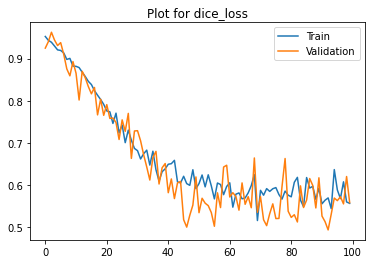

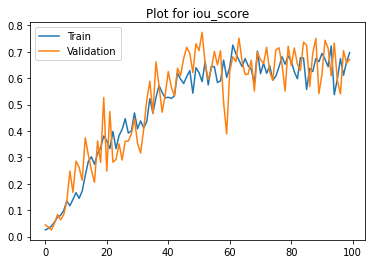

In [ ]:
# 101 plateu
plotter(train_logs_list,valid_logs_list,params)

In [ ]:
best_iou_score = 0.0
test_logs_list = []

for i in range(0, EVALUATE_EPOCHS):

    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    test_logs = valid_epoch.run(valid_loader)
    test_logs_list.append(test_logs)

    # Save model if a better val IoU score is obtained
    if best_iou_score < test_logs['iou_score']:
        best_iou_score = test_logs['iou_score']



print(f'------------\nValidation scores:\n {list_dict_mean(test_logs_list)}\n------------')


Epoch: 0
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  5.01it/s, dice_loss - 0.5497, iou_score - 0.7157]

Epoch: 1
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  6.35it/s, dice_loss - 0.5749, iou_score - 0.7003]

Epoch: 2
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  6.25it/s, dice_loss - 0.5011, iou_score - 0.6938]

Epoch: 3
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  6.40it/s, dice_loss - 0.5492, iou_score - 0.6288]

Epoch: 4
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  6.30it/s, dice_loss - 0.5644, iou_score - 0.7242]

Epoch: 5
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  6.33it/s, dice_loss - 0.4966, iou_score - 0.7806]

Epoch: 6
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  6.49it/s, dice_loss - 0.4987, iou_score - 0.7618]

Epoch: 7
valid: 100%|███████████████████████████████████████| 4/4 [00:00<00:00,  6.63it/s

In [10]:
import numpy as np

In [11]:
a = load_sparce_npz(r"C:\diploma\datasets\imageTBAD_Full\masks\Copy6_184.pickle")

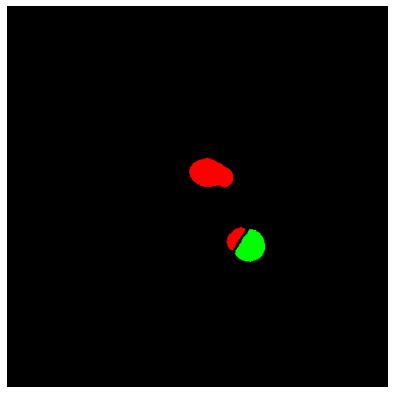

In [16]:
plt.figure(figsize=(7,7))
plt.imshow(a)
plt.axis('off')
plt.show()